In this notebook, I'll provide an wide overview on Automatic Speech Architecture, its standard pipelines, and how to train a model for it!

### What is Automatic Speech Recognition?
Automatic Speech Recognition (ASR) is the translation of spoken speech to text by a computer.

It has many uses:
+ closed captioning
+ mobile phone voice assistants
+ interface for handicapped individuals
+ preserve endangered languages

However, ASR is very difficult to solve due to:
+ Environment (Is there noise? Other speakers?)
+ Style of speech (Is it casual, formal, poetic, etc?)
+ Style of speaker (Talks fast? Accents? Gender bias?)

https://www.youtube.com/watch?v=q67z7PTGRi8

Modern ASR models work quite well in ideal, noiseless conditions. However, in noisy conditions they are far from perfect. Below, we can see the typical accuracy for state-of-the-art ASR models in 2020!

(Note: To calculate the accuracy of ASR models, we use a 'Word Error Rate.' This determines which percentage of spoken words were incorrectly translated to text by the ASR model. )

![word error rate](https://drive.google.com/uc?export=view&id=1iUz9koIqQErBVB0a4db0gSZVdfsfwh9L)



Architecture:

![timeline](https://drive.google.com/uc?export=view&id=1n2ID2ML5x9TFSBJhfdvj5AGI4u-9Mp4m)


From the 1980s to the 2010s, ASR was predominately performed by Hidden Markov Model (HMM) architecture. HMMs are probabilistic models for linear sequence classification problems. Given text's linear nature, HMMs seem like a natural fit for ASR.
However, using HMMs for ASR come with 3 downsides:
+ HMMs are built on the Markov Assumption, which assumes that the probability of the next state only depends on the current state, and not any states prior. This doesn't make sense for language processing, which is highly contextual (see Coarticulation)
+ HMMs' state transitions probabilities are 'baked in' and thus inflexible to changes in language
+ Classic HMM ASR pipelines require hand-tuned probability distributions for accoustic models and language models from linguistic experts
+ HMM-based ASR architecture is very complex, requiring 3 models as input. The figure below demonstrates an HMM-centric ASR architecture

![an HMM-based architecture](https://drive.google.com/uc?export=view&id=1loF8wbD-6DRO45Ly7lKnVVIcCn83H-B9)

Nowadays Recurrent Neural Networks (RNNs) or RNN-HMM hybrids are favored for ASR because they solve these problems. However, RNN's come at the cost of requiring a vast amount of training data.

![an RNN-only architecture](https://drive.google.com/uc?export=view&id=1_9McwMlHIqlPuJGYOkPwB-8h-t13P4pI)
(an RNN-only model that has only 4 steps)

https://stats.stackexchange.com/questions/282987/hidden-markov-model-vs-recurrent-neural-network
Jurafsky textbook

For the our ASR model, we'll be using an 'Listen, Attend, and Spell' (LAS) RNN. The LAS was proposed by in 2016 for ASR architecture in order to simplify Hybrid architecture (such as DNN-HMMs or CTC-HMMs) and avoid the aforementioned independence assumptions. Since then it has been the forefront of ASR architecture.

https://storage.googleapis.com/pub-tools-public-publication-data/pdf/44926.pdf

The objective of LAS is to transform an arbitrary-length input sequence to an arbitrary-length output sequence. LAS is an encoder-decoder model- a class of RNN's that is well-suited for problems where the length of the inputs greatly differs from the length of the outputs (like ASR).

Encoder-Decoder models are composed of 3 parts:
+ an Encoder
+ a Context Vector
+ a Decoder

The Encoder compresses and summarizes input data into a Context Vector, which is later transformed by the Decoder. The Context Vector must be defined with a fixed-length (usually 256, 512, or 1024).

Accoustic Information as Input for RNN:
A classic HMM-based ASR model would require us to input 3 probabilistic models (accoustic, pronunciation, and language), whereas an RNN only requires 1 (accoustic). The accoustic model captures important characteristics about how we perceive speech (see MFCC). We'll extract this data from the LibriSpeech ASR dataset.

https://www.openslr.org/12

We need to first extract features from the audio files- we'll be putting these features in a vector and feeding them into the RNN.
In order to extract the features from a given file, we need to perform the following steps:
```
1) Convert the FLAC file into a Waveform (giving us frequency data over the time domain)
2) Split the Waveform into Windows using a Windowing Function (like Hamming)
3) For each Window:
    a) Compute its Fourier Transform
    b) Compute its Mel Spectrogram (also known as Mel Filter Bank)
    c) Compute the Log of each value in the Mel Spectrogram
    d) Append the result of 3c to the Features Vector
4) Return Features Vector
```

Before do any computations, let's define some configuration constants:

In [1]:
sample_rate = 16000  # The Sample Rate of the LibriSpeech Dataset
window_size = int(sample_rate * 0.025)  # The standard window size for ASR models is 25ms
window_step = int(sample_rate * 0.010) # The standard window step for ASR models is 10ms


Now, the Log Mel Spectrogram may be computed as follows:

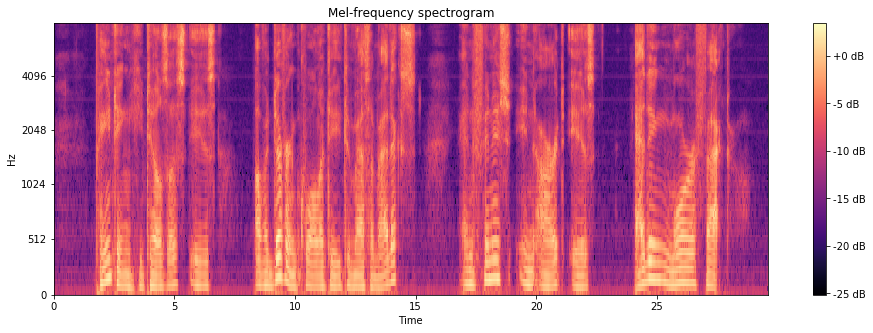

In [4]:
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt

def file_to_log_mel(filepath, sample_rate, window_size, window_step):  # LibriSpeech uses a 16kHz sample rate
    """ Convert an audio file to a Log Mel Spectrogram """
    audio_data, sample_rate = librosa.load(filepath, sr=sample_rate)
    mel_spec = librosa.feature.melspectrogram(audio_data, sample_rate, n_fft=window_size, hop_length=window_step, window="hann")
    log_mel_spec = np.log(mel_spec)
    return log_mel_spec

def show_spec(signal, sample_rate):
    """ Display a spectrogram plot """
    fig, ax = plt.subplots(figsize=(16,5))
    img = librosa.display.specshow(signal, x_axis='time', y_axis='mel', sr=sample_rate, fmax=8000, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram')

# Example
demo_path = './data/LibriSpeech/dev-clean/1272/128104/1272-128104-0007.flac'
log_mel_spec = file_to_log_mel(demo_path,sample_rate, window_size, window_step)
show_spec(log_mel_spec,sample_rate)

Sometimes you may see MFCCs used as the ASR features instead of Mel Filter Banks. MFCCs are values that loosely represents the brain's capacity to filter out certain signals. MFCCs were popular with HMM-based models for helping model based on human-perceptible information, but newer architecture can usually use Filter Banks without losing accuracy.

The diagram below shows the steps required for calculating the Filter Banks and MFCCs. As you can see, MFCCs require a few more calculations after the Filter Banks:

![features pipeline](https://drive.google.com/uc?export=view&id=15T0MgXcj9wA_ZQ_i4tCLukUCH-7T2FnB)

https://www.youtube.com/watch?v=QTw-6GU5Mjs&t=319s
https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

Let's also add a helper function that'll allow us to map the spectrograms to their target text! Specifically, this function will Tokenize the target text (i.e. split the text by character):

In [5]:
def tokenize(dir_path, found_characters_total:set, file_ext="*.txt"):
    """ For every file with the given file extension in a directory, split them by line and tokenize them.
    Returns a dictionary of the filename-characters pairs, and adds found chars to the given set found_characters_total"""
    dict = {}
    text_files = glob.glob(os.path.join(dir_path, file_ext))
    targets_file_name = text_files[0]
    targets_file = open(targets_file_name, 'r')
    lines = targets_file.read().split('\n')[:-1]
    for i, line in enumerate(lines):
        delimiter = line.index(' ')
        id = line[:delimiter]
        sentence = line[delimiter:]
        found_chars_in_sentence = set()
        for char in sentence:
            if char not in found_chars_in_sentence:
                found_chars_in_sentence.add(char)
            if char not in found_characters_total:
                found_characters_total.add(char)
        dict[id] = sorted(list(found_chars_in_sentence))
    return dict

Now we can extract features and target text from the whole LibriSpeech dataset!

In [187]:
import glob, os

def normalize(signal):
    """ WIP """
    return (signal - signal.mean()) / (signal.std())

def extract_features_and_text_targets(parent_dir, file_ext="*.flac"):
    """ Iterate through LibriSpeech Dataset.
     Returns (the input array of Log Mel Filter Bank Values, the output array of target characters) """
    log_specgrams = []
    target_text_chars = []
    total_found_chars = set()
    ext_len = len(file_ext) - 1
    sub_dirs = os.listdir(parent_dir)
    for i,sub_dir_1 in enumerate(sub_dirs):
        sub_dirs_2 = os.listdir(os.path.join(parent_dir, sub_dir_1))
        for j,sub_dir_2 in enumerate(sub_dirs_2):
            folder_path = os.path.join(parent_dir, sub_dir_1, sub_dir_2)
            output_text_dict = tokenize(folder_path, total_found_chars)
            for fn in glob.glob(folder_path+'/'+file_ext):
                # Extract features
                spec =normalize(file_to_log_mel(fn, sample_rate))  # because NN's work best with normalized data
                log_specgrams.append(spec)
                # Append a list of characters in the target sentence
                base_name = os.path.basename(fn)[:-ext_len]
                target_text_chars.append(output_text_dict[base_name])
    num_target_text_tokens = len(total_found_chars)
    return log_specgrams, target_text_chars, total_found_chars, num_target_text_tokens

[' ', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']
[' ', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'W', 'Y', 'Z']
[' ', 'A', 'B', 'C', 'D', 'E', 'F', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']
[' ', 'A', 'B', 'D', 'E', 'G', 'H', 'I', 'L', 'N', 'O', 'P', 'R', 'S', 'T', 'U']
[' ', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'O', 'R', 'S', 'T', 'U', 'Y']
[' ', 'A', 'B', 'D', 'E', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'R', 'S', 'T', 'U', 'W', 'Y']
[' ', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'W', 'Y']
[' ', 'A', 'D', 'E', 'G', 'H', 'I', 'K', 'L', 'N', 'P', 'R', 'S', 'T', 'V', 'W', 'Y']
[' ', "'", 'A', 'D', 'E', 'G', 'H', 'I', 'K', 'N', 'O', 'P', 'R', 'S', 'T', 'W', 'Y']
[' ', "'", 'A', 'D', 'E', 'H', 'K', 'L', 'N', 'O', 'R', 'S', 'T', 'W']
[' ', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K',

Even though we have the spectrograms of audio recordings and their respective text translations, the Neural Network will not be able to read them in this format. We'll need to define the following variables so that both the encoder and decoder can run:

In [ ]:
num_encoder_tokens = None  #
num_decoder_tokens = None
encoder_input_data = None
decoder_input_data = None
max_encoder_seq_length = None
max_decoder_seq_length = None

decoder_target_data = None

In [ ]:

    # target_token_index = dict([(char, i) for i, char in enumerate(total_found_chars)])

def get_decoder_data():  # populate 2 arrays, offset by 1
    decoder_input_data = np.zeros(
        (num_output, max_decoder_seq_length, num_decoder_tokens), dtype="float32"
    )
    decoder_target_data = np.zeros(
        (num_output, max_decoder_seq_length, num_decoder_tokens), dtype="float32"
    )
    for char in found_chars:
        idx =target_token_index[char]
        array[idx] = 1.0

        # How do we do input/output arrays of diffff length?
        # https://keras.io/examples/nlp/lstm_seq2seq/
        # https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/nlp/ipynb/lstm_seq2seq.ipynb#scrollTo=Tp6YF0oHXgay
        # https://medium.com/deep-learning-with-keras/seq2seq-part-e-encoder-decoder-for-variable-input-output-size-with-teacher-forcing-92c476dd9b0



In [ ]:
# add function to AudioHandler
log_specgrams, \
target_text_chars, \
total_found_chars, \
num_target_text_tokens = extract_features_and_text_targets('./data_test/LibriSpeech/dev-clean/')
# https://www.kdnuggets.com/2017/12/audio-classifier-deep-neural-networks.html

 and Numericize them (i.e. assign integers to each token)

In [122]:
target_token_index = None  # A dict mapping an integer to each seen character
encoder_input_data = None
decoder_input_data = None  # An array of dicts mapping characters to whether 1 if seen, 0 if not seen
decoder_target_data = None  # An array of dicts mapping characters to whether 1 if seen, 0 if not seen


1272-135031-0002
1272-135031-0003
1272-135031-0018
1272-135031-0019
1272-135031-0011
1272-135031-0022
1272-135031-0020
1272-135031-0007
1272-135031-0006
1272-135031-0009
1272-135031-0014
1272-135031-0010
1272-135031-0013
1272-135031-0017
1272-135031-0021
1272-135031-0000
1272-135031-0005
1272-135031-0023
1272-135031-0016
1272-135031-0008
1272-135031-0012
1272-135031-0001
1272-135031-0015
1272-135031-0004
1272-135031-0024
1272-128104-0005
1272-128104-0008
1272-128104-0014
1272-128104-0011
1272-128104-0001
1272-128104-0013
1272-128104-0012
1272-128104-0004
1272-128104-0007
1272-128104-0002
1272-128104-0003
1272-128104-0000
1272-128104-0009
1272-128104-0006
1272-128104-0010
1272-141231-0011
1272-141231-0018
1272-141231-0030
1272-141231-0013
1272-141231-0012
1272-141231-0010
1272-141231-0019
1272-141231-0022
1272-141231-0006
1272-141231-0032
1272-141231-0001
1272-141231-0025
1272-141231-0027
1272-141231-0026
1272-141231-0015
1272-141231-0003
1272-141231-0024
1272-141231-0028
1272-141231-00

[]

In [ ]:

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
data_path = "./data/LibriSpeech/dev-clean/1272/128104/1272-128104-0000.flac"




In [109]:
import keras

encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))


<module 'keras.datasets.boston_housing' from '/home/a/.local/lib/python3.8/site-packages/keras/datasets/boston_housing.py'>



Next: build encoder-decoder architecture, based on https://github.com/tensorflow/nmt

Next: plug into RNN, run it on Google Colab. Save it

Next: let user input voice data, and run it through the model

More soucres
https://towardsdatascience.com/recognizing-speech-commands-using-recurrent-neural-networks-with-attention-c2b2ba17c837
https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html
https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/
https://arxiv.org/pdf/1409.0473.pdf


Further Optimizations:

The Context Vector being fixed-length turns out to be a performance bottleneck; given a long input sentences, the the Encoder may not be able to store all of its output in the Context Vector in one timestep.

To solve the bottleneck, we could use the 'attention' mechanism which involves the Decoder selecting from all hidden states provided by the Encoder. For the sake of simplicity we won't be doing this optimization.
